# Coffee Usage

Python notebook for analysing the coffee usage in the NBI HEP group, and determining the length of the Christmas vacation from a fit to it. The exercise lies in writing a stepwise fit function, and making it work on real data.

For a period in 2009-2010, the usage of the old coffey machine in the NBI HEP group was (somewhat irregularly) monitored. Below is the count of total number of cups of coffey ever brewed at given dates. We will mainly focus on the data from around Christmas...


- 28479   4/11-2009     NOTE: This day, we in the following define as day 0! 
- 28674  13/11-2009 
- 28777  18/11-2009 
- 28964  25/11-2009 
- 29041  27/11-2009 
- 29374  10/12-2009 
- ~29650   8/ 1-2010
- 30001  29/ 1-2010 (?)
- 30221   8/ 2-2010
- 30498  21/ 2-2010
- 32412  17/ 5-2010
- 33676  11/ 8-2010
- 34008   9/ 9-2010`

### Author: 
- Troels C. Petersen (Niels Bohr Institute)

### Date:    
- 29-11-2022 (latest update)

***

In [757]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Modules to see files and folders in directories
from scipy import stats, optimize

Load the external functions:

In [758]:
sys.path.append('../../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax    # Useful functions to print fit results on figure

and define the parameters of the program:

In [759]:
save_plots = False

## Fitting functions:

First we define a simple linear function:

In [760]:
def func_coffee_simple(x, p0, p1): 
    return p0 + p1*x

Now YOU should add an extra parameter, which is the length of the vacation:

In [761]:
def func_coffee_advanced(x, p0, p1, p2):

    if x <= 36:
        return p0 + p1 * x
    else:
        return p1 * x + p0 - p1 * p2
    
# Numpy-way of "vectorizing" the function above:
func_coffee_advanced_vec = np.vectorize(lambda x, p0, p1, p2: func_coffee_advanced(x, p0, p1, p2))

The reason why we are using the last line is to allow `func_coffee_advanced` to take Numpy arrays as inputs, so we do not have to loop over entire lists.

## Coffee Usage

Data set (So small that we will not use a seperate file for it!). We define 4th of November 2009 to be day 0, and count from there.

In [762]:
days = np.array([     0,     9,    14,    21,    23,    36,    65,    76,    86,    99,   194,   280,   309 ])
cups = np.array([ 28479, 28674, 28777, 28964, 29041, 29374, 29650, 30001, 30221, 30498, 32412, 33676, 34008 ])
edays = np.zeros_like(days)
ecups = np.ones_like(cups)*30.0   # I estimate the uncertainty to be 30 cups, but perhaps you disagree?
                                  # Certainly, it is NOT the square root, as it is not at all a Poisson number!

# Print the number of days:
for day, cup in zip(days, cups):
    print(f"days: {day:3.0f}    cups: {cup:5.0f}")

days:   0    cups: 28479
days:   9    cups: 28674
days:  14    cups: 28777
days:  21    cups: 28964
days:  23    cups: 29041
days:  36    cups: 29374
days:  65    cups: 29650
days:  76    cups: 30001
days:  86    cups: 30221
days:  99    cups: 30498
days: 194    cups: 32412
days: 280    cups: 33676
days: 309    cups: 34008


## Fit and plot graph on screen:

In [763]:
# Define the relevant range:
xmin, xmax = 60, 105
mask_range = (xmin < days) & (days < xmax)

# Fit the data points in the range (xmin, xmax)
chi2_object_coffee = Chi2Regression(func_coffee_simple, days[mask_range], cups[mask_range], ecups[mask_range])
minuit_coffee = Minuit(chi2_object_coffee, p0=28000.0, p1=20.0)
minuit_coffee.errordef = 1.0   # Chi2 fit
minuit_coffee.migrad();
p0, p1 = minuit_coffee.values[:]

print("Simple fit")
for name in minuit_coffee.parameters:
    print("Fit value: {0} = {1:.5f} +/- {2:.5f}".format(name, minuit_coffee.values[name], minuit_coffee.errors[name]))

Simple fit
Fit value: p0 = 28086.87440 +/- 98.63570
Fit value: p1 = 24.60890 +/- 1.19618


Plot the data along with the fit on top of the data:

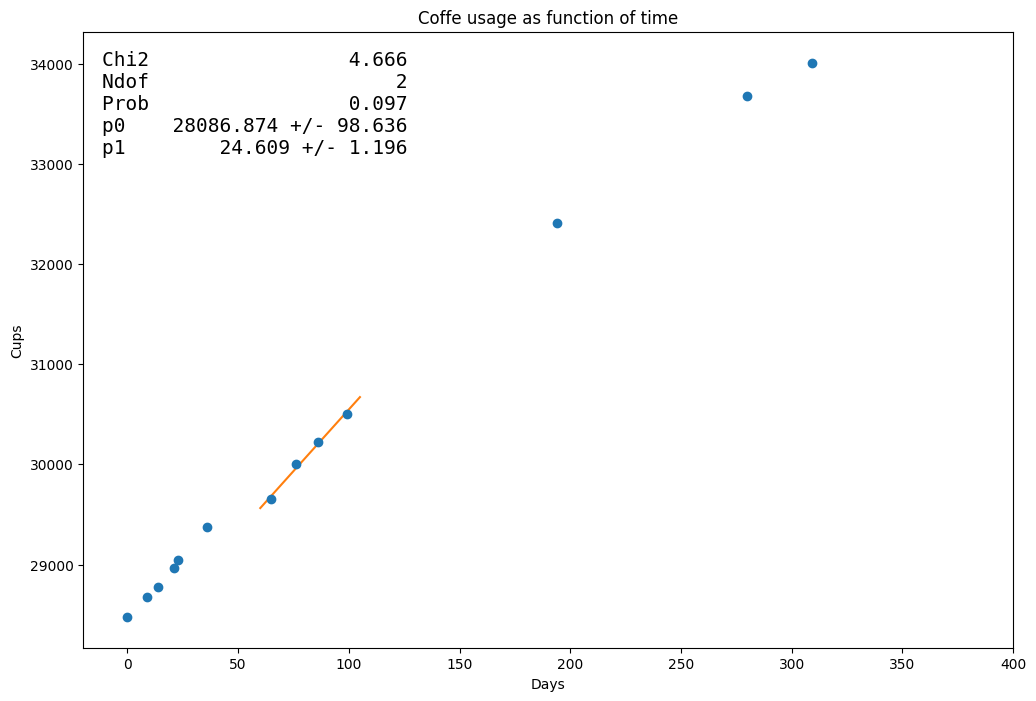

In [764]:
# Plot the data:
fig, ax = plt.subplots(figsize=(12, 8))
ax.errorbar(days, cups, xerr=edays, yerr=ecups, fmt='o', label='Data')
ax.set(xlim=(-20, 400), xlabel='Days', ylabel='Cups', title='Coffe usage as function of time')

# Plot the fit on top:
x_fit = np.linspace(xmin, xmax, 1000)
y_fit = func_coffee_simple(x_fit, *minuit_coffee.values[:])
ax.plot(x_fit, y_fit, '-', label='Simple Fit')

# Get the ChiSquare probability:
chi2_lin = minuit_coffee.fval
ndof_lin = len(days[mask_range]) - len(minuit_coffee.values[:])
chi2_prob_lin = stats.chi2.sf(chi2_lin, ndof_lin)

# Include fit results in the plot:
d = {'Chi2': chi2_lin,
     'Ndof': ndof_lin,
     'Prob': chi2_prob_lin,
     'p0': [minuit_coffee.values['p0'], minuit_coffee.errors['p0']],
     'p1': [minuit_coffee.values['p1'], minuit_coffee.errors['p1']],
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.97, text, ax, fontsize=14);


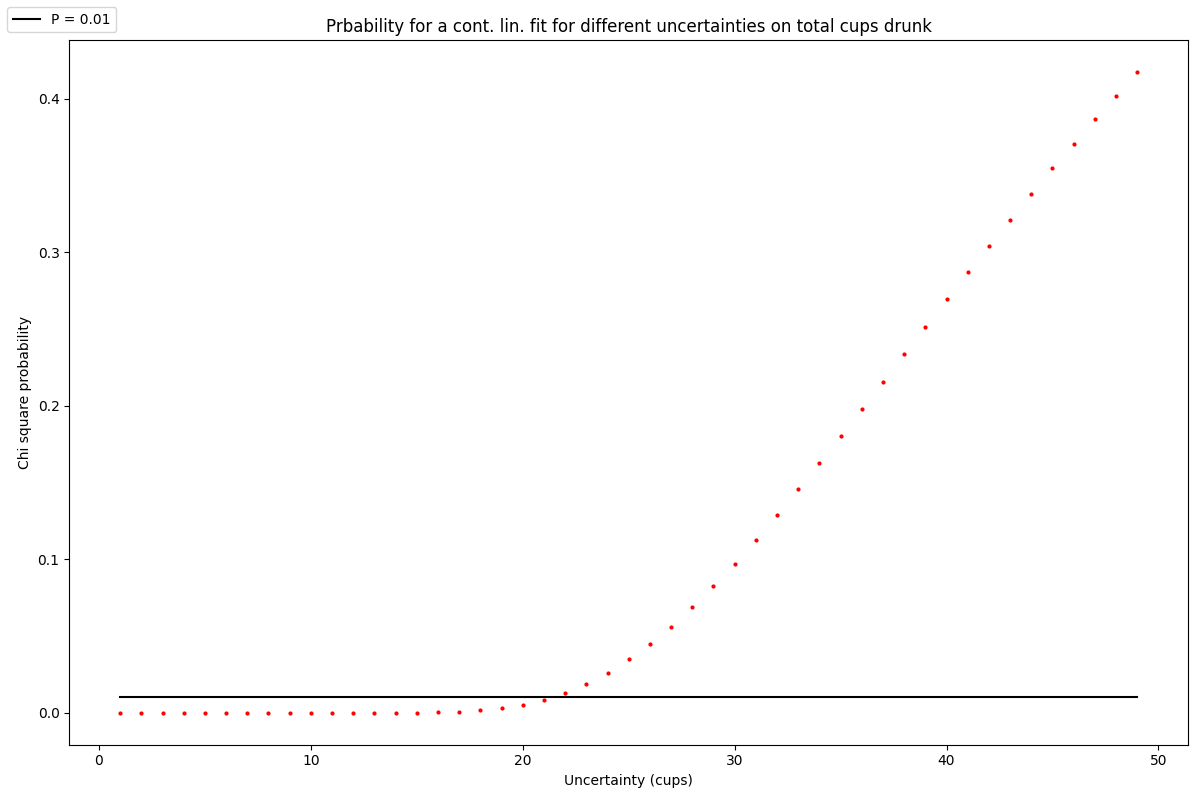

In [765]:
# Define the relevant range:

xmin, xmax = 60, 105
mask_range = (xmin < days) & (days < xmax)
p_vals = []
for i in range(1,50):
    ecups = i * np.ones_like(cups).astype('int')
    # Fit the data points in the range (xmin, xmax)
   # func_coffee_simple_vec = np.vectorize(func_coffee_simple)
    chi2_object_coffee = Chi2Regression(func_coffee_simple, days[mask_range], cups[mask_range], ecups[mask_range])
    minuit_coffee = Minuit(chi2_object_coffee, p0=28000.0, p1=20.0)
    minuit_coffee.errordef = 1.0   # Chi2 fit
    minuit_coffee.migrad();
    p0, p1 = minuit_coffee.values[:]

    # Get the ChiSquare probability:
    chi2_lin = minuit_coffee.fval
    ndof_lin = len(days[mask_range]) - len(minuit_coffee.values[:])
    chi2_prob_lin = stats.chi2.sf(chi2_lin, ndof_lin)
    p_vals.append(chi2_prob_lin)

# Plot probability that a constant number of cups is drunk every day in the given ray for different uncertainties on the
# total number of coffee cups drunk
fig_p, ax_p = plt.subplots(figsize = (12,8))
counts = np.arange(1,50)
ax_p.plot(counts, p_vals, 'ro', markersize = 2)
ax_p.plot([np.min(counts), np.max(counts)], [0.01, 0.01], 'k-', label = 'P = 0.01')
ax_p.set(title = 'Prbability for a cont. lin. fit for different uncertainties on total cups drunk', xlabel = 'Uncertainty (cups)', 
ylabel = 'Chi square probability')
fig_p.legend(loc = 'upper left')
fig_p.tight_layout()


## Advanced fit:
Try to fit the advanced function in the range (-10, 110):

In [766]:
# Define the relevant range:
xmin, xmax = -10, 110
mask_range = (xmin < days) & (days < xmax)
ecups = 22 * np.ones_like(days)

# Fit the data points in the range (xmin, xmax)
chi2_object_coffee = Chi2Regression(func_coffee_advanced, days[mask_range], cups[mask_range], ecups[mask_range])
minuit_coffee = Minuit(chi2_object_coffee, p0=28000.0, p1=20.0, p2 = 20)
minuit_coffee.errordef = 1.0   # Chi2 fit
minuit_coffee.migrad();
p0, p1, p2 = minuit_coffee.values[:]

print("Advanced fit")
for name in minuit_coffee.parameters:
    print("Fit value: {0} = {1:.5f} +/- {2:.5f}".format(name, minuit_coffee.values[name], minuit_coffee.errors[name]))

Advanced fit
Fit value: p0 = 28457.63102 +/- 13.50013
Fit value: p1 = 24.88554 +/- 0.58711
Fit value: p2 = 15.80515 +/- 1.27921


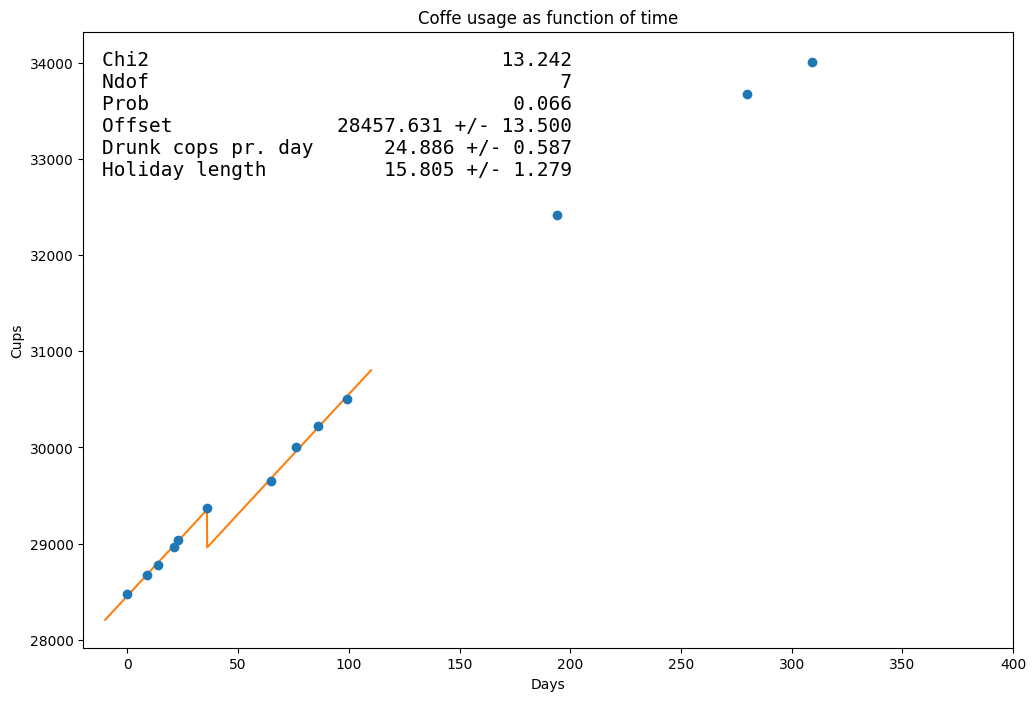

In [767]:
# Plot the data:


fig_ad, ax_ad = plt.subplots(figsize=(12, 8))
ax_ad.errorbar(days, cups, xerr=edays, yerr=ecups, fmt='o', label='Data')
ax_ad.set(xlim=(-20, 400), xlabel='Days', ylabel='Cups', title='Coffe usage as function of time')

# Plot the fit on top:
x_fit = np.linspace(xmin, xmax, 1000)
y_fit = func_coffee_advanced_vec(x_fit, *minuit_coffee.values[:])
ax_ad.plot(x_fit, y_fit, '-', label='Advanced Fit')

# Get the ChiSquare probability:
chi2_lin = minuit_coffee.fval
ndof_lin = len(days[mask_range]) - len(minuit_coffee.values[:])
chi2_prob_lin = stats.chi2.sf(chi2_lin, ndof_lin)

# Include fit results in the plot:
d = {'Chi2': chi2_lin,
     'Ndof': ndof_lin,
     'Prob': chi2_prob_lin,
     'Offset': [minuit_coffee.values['p0'], minuit_coffee.errors['p0']],
     'Drunk cops pr. day': [minuit_coffee.values['p1'], minuit_coffee.errors['p1']],
     'Holiday length': [minuit_coffee.values['p2'], minuit_coffee.errors['p2']]
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.97, text, ax_ad, fontsize=14);

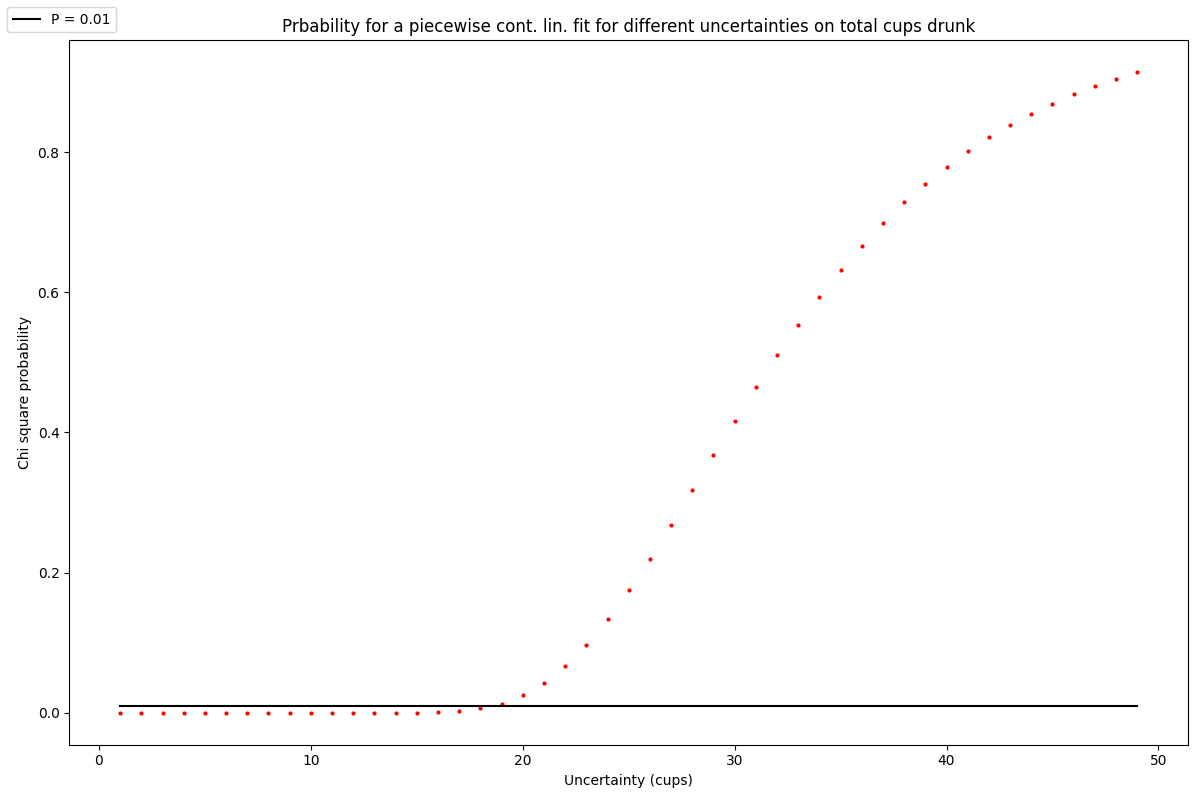

In [768]:
# Define the relevant range:

#xmin, xmax = -10, 110
mask_range = (xmin < days) & (days < xmax)
p_vals = []
for i in range(1,50):
    ecups = i * np.ones_like(cups).astype('int')
    # Fit the data points in the range (xmin, xmax)
   # func_coffee_simple_vec = np.vectorize(func_coffee_simple)
    chi2_object_coffee = Chi2Regression(func_coffee_advanced, days[mask_range], cups[mask_range], ecups[mask_range])
    minuit_coffee = Minuit(chi2_object_coffee, p0=28000.0, p1=20.0, p2 = 20)
    minuit_coffee.errordef = 1.0   # Chi2 fit
    minuit_coffee.migrad();
    p0, p1, p2 = minuit_coffee.values[:]

    # Get the ChiSquare probability:
    chi2_lin = minuit_coffee.fval
    ndof_lin = len(days[mask_range]) - len(minuit_coffee.values[:])
    chi2_prob_lin = stats.chi2.sf(chi2_lin, ndof_lin)
    p_vals.append(chi2_prob_lin)

# Plot probability that a constant number of cups is drunk every day in the given ray for different uncertainties on the
# total number of coffee cups drunk
fig_p, ax_p = plt.subplots(figsize = (12,8))
counts = np.arange(1,50)
ax_p.plot(counts, p_vals, 'ro', markersize = 2)
ax_p.plot([np.min(counts), np.max(counts)], [0.01, 0.01], 'k-', label = 'P = 0.01')
ax_p.set(title = 'Prbability for a piecewise cont. lin. fit for different uncertainties on total cups drunk', xlabel = 'Uncertainty (cups)', 
ylabel = 'Chi square probability')
fig_p.legend(loc = 'upper left')
fig_p.tight_layout()


# Questions:

First, only consider the first 100 days of data.

0. From the ChiSquare of the linear fit to four points (65-100 days), is the estimated uncertainty of 30 cups reasonable?
- 30 is a reasonable uncertainty, given that is results in a valid linear with P = 0.097. Using 25 gives P = 0.037, whereas
20 results in P < 0.01

1. Assuming the error of 30 cups, do the numbers follow the hypothesis of constant use? Quantify this, and find out how large the error has to be (roughly), for this hypothesis to be credible.
- Using that P > 0.01 for the hypothesis to be valid, we find that the error must be at least 22 for this criterion to be
satisied

2. Does taking into account Christmas vacation looks like it will improve the above hypothesis? Can you actually fit the length of vacation? Try to rewrite the function "func_coffee_advanced", such that it includes "if", dividing the function into two linear functions with the same slope, that has an interval with no usage (i.e. the Christmas vacation). What length do you obtain? And how much better is the model?
- Yes! We find the holiday length to be app. 14-16 days.
- Using P>0.01 as a succes criterion for the linear fit, including the break reduces the min. necessary uncertainty from
22 to 19.
- Also, the uncertainty on p0 and p1 are reduced in the extended fit

Now consider the whole data set.





In [769]:
#assuming no breaks between 

In [770]:
##EXTENDED advanced fit

p0_old = 28457.61849
p1_old = 24.88644
p2_old = 15.80648
p3_old = 19.29644


def func_coffee_advanced_ext(x, p4, p5, p0 = p0_old, p1 = p1_old, p2 = p2_old, p3 = p3_old):
    sommer_break = 225 ## 1st of July 2010
    if x <= 36:
        return p0 + p1 * x
    elif 36 < x <= 99:
        return p1 * x + p0 - p1 * p2
    elif 99 < x <= sommer_break:
        return p1 * x + p0 - p1 * (p2 + p3)
    elif sommer_break < x < 310:
        return p4 * x + p0 - p1 * (p2 + p3) - p5 * p4 + sommer_break * ( p1 - p4)
    else:
        return p1 * x + p0 - p1 * (p2 + p3) - p5 * p4 + sommer_break * ( p1 - p4) + 310 * (p4 - p1)
    
# Numpy-way of "vectorizing" the function above:
func_coffee_advanced_ext_vec = np.vectorize(func_coffee_advanced_ext)

In [771]:
# Define the relevant range:
xmin, xmax = np.min(days) - 10, 365
mask_range = (xmin < days) & (days < xmax)
ecups = 30 * np.ones_like(days)

# Fit the data points in the range (xmin, xmax)
chi2_object_coffee = Chi2Regression(func_coffee_advanced_ext, days[mask_range], cups[mask_range], ecups[mask_range])
#minuit_coffee = Minuit(chi2_object_coffee, p0=28000.0, p1=25.0, p2 = 16, p3 = 19, p4 = 15)
minuit_coffee = Minuit(chi2_object_coffee, p0 = 28000, p1 = 24, p2 = 16, p3 = 19, p4 = 15, p5 = 10)
minuit_coffee.errordef = 1.0   # Chi2 fit
minuit_coffee.migrad();
p0, p1, p2, p3,p4, p5 = minuit_coffee.values[:]

print("Advanced fit")
for name in  minuit_coffee.parameters:
    print("Fit value: {0} = {1:.5f} +/- {2:.5f}".format(name, minuit_coffee.values[name], minuit_coffee.errors[name]))

Advanced fit
Fit value: p4 = 11.44821 +/- 1.45969
Fit value: p5 = 11.97772 +/- 8.30714
Fit value: p0 = 28457.62026 +/- 18.40234
Fit value: p1 = 24.88619 +/- 0.80014
Fit value: p2 = 15.80580 +/- 1.74559
Fit value: p3 = 19.29581 +/- 3.28933


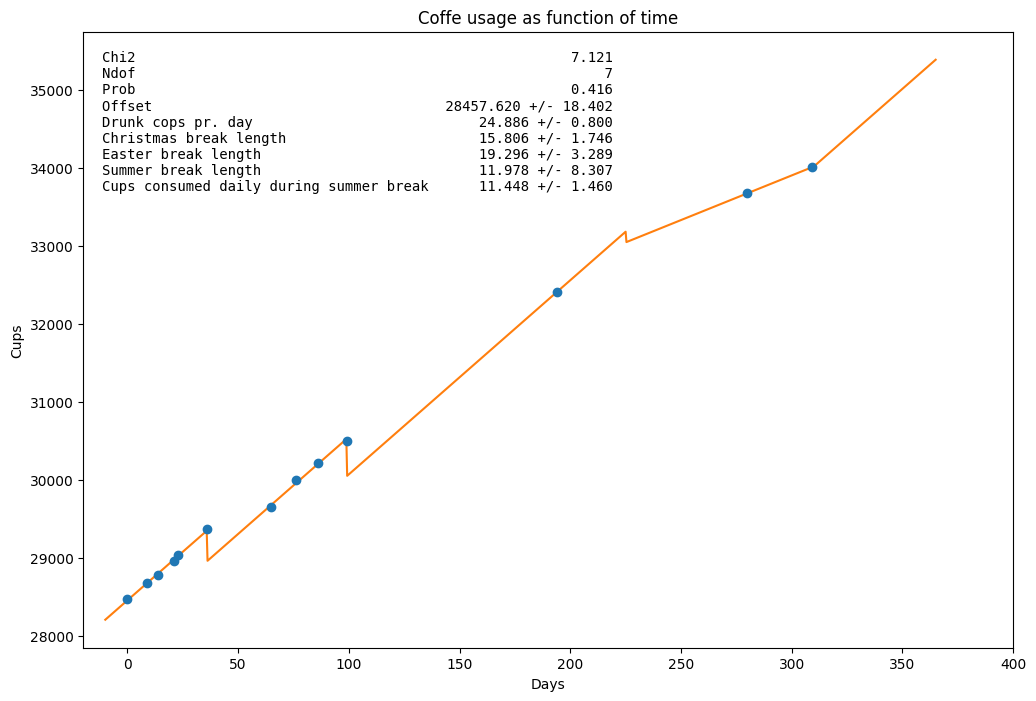

In [772]:
# Plot the data:


fig_ad, ax_ad = plt.subplots(figsize=(12, 8))
ax_ad.errorbar(days, cups, xerr=edays, yerr=ecups, fmt='o', label='Data')
ax_ad.set(xlim=(-20, 400), xlabel='Days', ylabel='Cups', title='Coffe usage as function of time')

# Plot the fit on top:
x_fit = np.linspace(xmin, xmax, 1000)
y_fit = func_coffee_advanced_ext_vec(x_fit, *minuit_coffee.values[:])
ax_ad.plot(x_fit, y_fit, '-', label='Advanced Fit')

# Get the ChiSquare probability:
chi2_lin = minuit_coffee.fval
ndof_lin = len(days[mask_range]) - len(minuit_coffee.values[:])
chi2_prob_lin = stats.chi2.sf(chi2_lin, ndof_lin)

# Include fit results in the plot:
d = {'Chi2': chi2_lin,
     'Ndof': ndof_lin,
     'Prob': chi2_prob_lin,
    'Offset': [minuit_coffee.values['p0'], minuit_coffee.errors['p0']],
     'Drunk cops pr. day': [minuit_coffee.values['p1'], minuit_coffee.errors['p1']],
     'Christmas break length': [minuit_coffee.values['p2'], minuit_coffee.errors['p2']],
          'Easter break length': [minuit_coffee.values['p3'], minuit_coffee.errors['p3']],
               'Summer break length': [minuit_coffee.values['p5'], minuit_coffee.errors['p5']],
     'Cups consumed daily during summer break': [minuit_coffee.values['p4'], minuit_coffee.errors['p4']]
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.97, text, ax_ad, fontsize=10);

3. The total number of cups of coffey ever brewed was 36716, after which the old coffey machine was decommissioned. From the above data, estimate when this happened (including error!). And when would you estimate that the coffey machine was commissioned originally?
To describe the entire data set well, we must take into account the easter and summer holidays as well

In [778]:
# We now have an estimate for the yearly coffee consumption
cups_yearly = y_fit[-1] - y_fit[0]
print("Estimation of no. cops drunk yearly: ", cups_yearly)

# assuming that this yearly consumption is constant, we make the rough scale extrapolation y = cups_yearly * t
y1 = y_fit[0]
y2 = y_fit[-1]

t1 = y1 / cups_yearly
t2 = y2/ cups_yearly

print(f"The coffee machine was commisioned an estimated {12 *t1:.2f} months before Nov. 4 2009")

## now, to find out when it was decomissioned, we'll use the coffee comsumptions of a year and coarsely assume this relationship is adequate(ignoring the christmas break)
y_critical = 36716
y_baseline = y_fit[-1]
dT = (y_critical - y_baseline) / cups_yearly

print(f"The coffee machine was decommisioned an estimated {12 *dT:.2f} months after Nov. 4 2010")

Estimation of no. cops drunk yearly:  7179.425136656009
The coffee machine was commisioned an estimated 47.15 months before Nov. 4 2009
The coffee machine was decommisioned an estimated 2.22 months after Nov. 4 2010


# Learning points:

From questions 0-2 you should learn how to make "complicated" fitting functions, which might include discontinuities or even more advanced parts (e.g. a simulation of the Universe or the likes)!

From question 3 you should learn how to extrapolate a fit into the future, and think about the pitfalls that such an extrapolation contains.